In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [5]:
df=pd.read_csv('/content/AIML Dataset.csv')

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [6]:
df['isFraud'].value_counts()

,count
isFraud,
0.0,14168
1.0,78


In [7]:
# Remove rows where the target 'isFraud' is missing
df = df[df['isFraud'].notna()]


In [14]:
for col in ['nameOrig', 'nameDest']:
    if col in df.columns:
        df = df.drop(columns=col)

In [15]:
df.columns


Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud',
       'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')

In [16]:
# Encode the 'type' feature using Label Encoding
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [17]:
# Feature Engineering: Create additional useful features
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [18]:
# Define features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [19]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
# Drop 'isFlaggedFraud' if it's not useful (you can keep it if needed)
if 'isFlaggedFraud' in df.columns:
    df = df.drop('isFlaggedFraud', axis=1)

In [20]:
# Apply SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.25, random_state=42, stratify=y_res
)

In [22]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# Train XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:17:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
# Predict
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]


In [25]:
# Evaluate
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

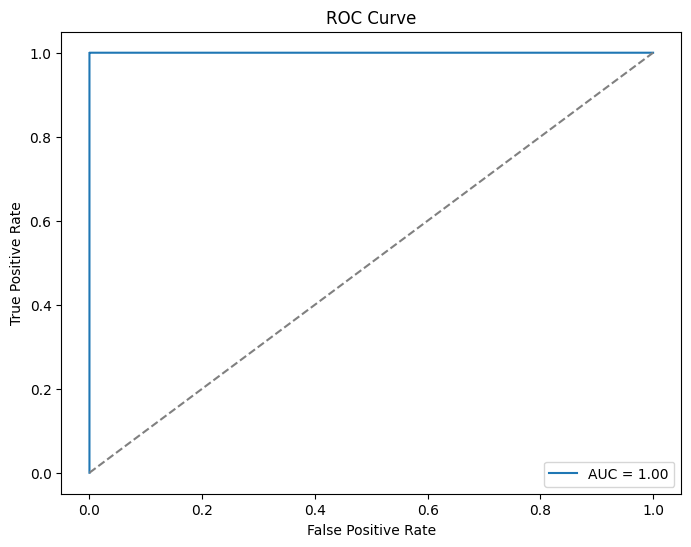

In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [27]:
# Feature Importance
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)

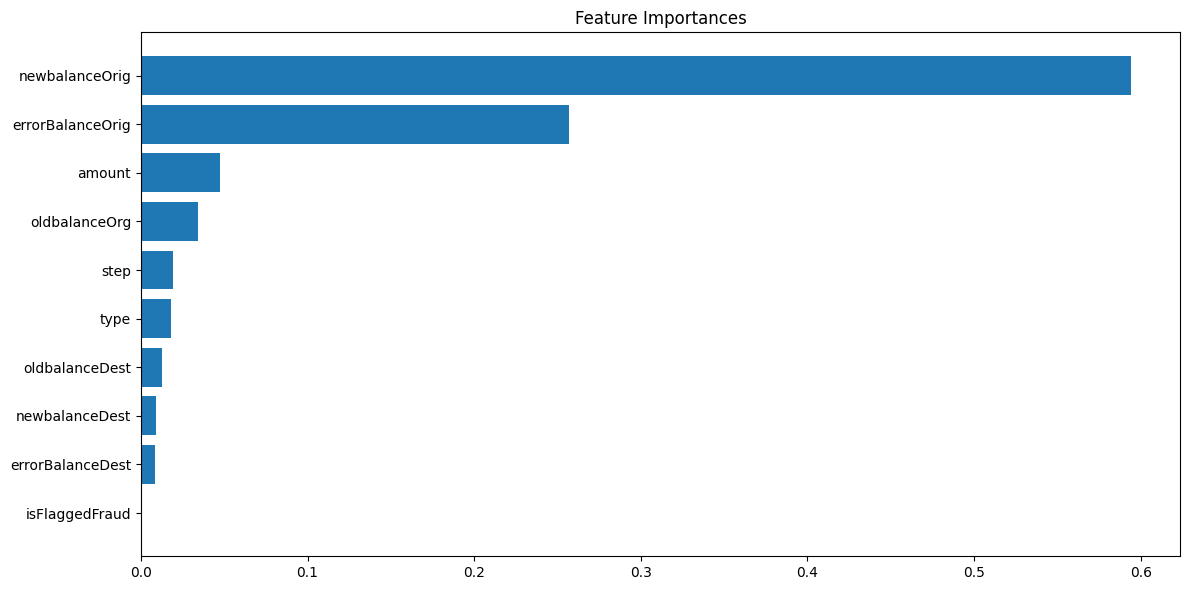

In [28]:
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Accuracy
print("# Accuracy:", round(accuracy * 100, 2), "%")

# ROC AUC Score
print("# ROC AUC Score:", round(roc_auc * 100, 2), "%")

# Confusion Matrix
print("# Confusion Matrix:\n", conf_matrix)

# Classification Report
print("# Classification Report:\n", class_report)

# Accuracy: 99.97 %
# ROC AUC Score: 100.0 %
# Confusion Matrix:
 [[3540    2]
 [   0 3542]]
# Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3542
         1.0       1.00      1.00      1.00      3542

    accuracy                           1.00      7084
   macro avg       1.00      1.00      1.00      7084
weighted avg       1.00      1.00      1.00      7084

